In [1]:
import os

import warnings
warnings.filterwarnings('ignore') # :clown:

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
import neurokit2 as nk

In [4]:
import multiprocessing
import joblib
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import matplotlib.dates as md

In [6]:
category_order = [
    'Lying_supine', 
    'Standing', 
    'Sitting', 
    'TA', 
    'Recov1', 
    'SSST_Sing_countdown', 
    'Recov2', 
    'Pasat', 
    'Recov3', 
    'Raven', 
    'Walking_own_pace', 
    'Walking_fast_pace', 
    'Cycling', 
    'stairs_up_and_down', 
    'Recov_standing', 
    'Dishes', 
    'Vacuum', 
    'Recov4', 
    'TA_repeat', 
    'Recov5', 
    'Pasat_repeat', 
    'Treadmill1', 
    'Treadmill2', 
    'Treadmill3', 
    'Treadmill4', 
    'Recov6',
    'Baseline'
]

In [7]:
def get_csv_file_paths(target):
    if os.path.isdir(target):
        file_paths = [os.path.join(target, f) for f in os.listdir(target) if f.endswith('.csv')]
    elif os.path.isfile(target):
        file_paths = [target]
    else:
        raise Exception('Target is not a file or directory.')

    return file_paths

In [8]:
paths = get_csv_file_paths('../data/ecg_preprocessed/')

In [9]:
def calculate_heart_rate(path):
    df = pd.read_csv(
        path, 
        skiprows=[0],
        names=['timestamp','signal','signal_normalised','subject_id','category','code','ECG_Raw','ECG_Clean','ECG_Rate','ECG_Quality','ECG_R_Peaks','ECG_P_Peaks','ECG_P_Onsets','ECG_P_Offsets','ECG_Q_Peaks','ECG_R_Onsets','ECG_R_Offsets','ECG_S_Peaks','ECG_T_Peaks','ECG_T_Onsets','ECG_T_Offsets','ECG_Phase_Atrial','ECG_Phase_Completion_Atrial','ECG_Phase_Ventricular','ECG_Phase_Completion_Ventricular','Index','Label'],#,'heartbeat'],
        dtype={
            'timestamp': str, 
            'signal': float, 
            'signal_normalised': float, 
            'subject_id': str, 
            'category': str, 
            'code': str, 
            'ECG_Raw': float, 
            'ECG_Clean': float, 
            'ECG_Rate': float, 
            'ECG_Quality': float, 
            'ECG_R_Peaks': float, 
            'ECG_P_Peaks': float, 
            'ECG_P_Onsets': float, 
            'ECG_P_Offsets': float, 
            'ECG_Q_Peaks': float, 
            'ECG_R_Onsets': float, 
            'ECG_R_Offsets': float, 
            'ECG_S_Peaks': float, 
            'ECG_T_Peaks': float, 
            'ECG_T_Onsets': float, 
            'ECG_T_Offsets': float, 
            'ECG_Phase_Atrial': float, 
            'ECG_Phase_Completion_Atrial': float, 
            'ECG_Phase_Ventricular': float, 
            'ECG_Phase_Completion_Ventricular': float, 
            'Index': 'Int64', 
            'Label': str, 
            # 'heartbeat': int  
        }
    )
    rate = df.groupby('category')['ECG_Rate'].agg(['mean', 'median']).reset_index()
    rate.rename(inplace=True, columns={'mean': 'mean_hr', 'median': 'median_hr'})
    rate['subject_id'] = df['subject_id'].iloc[0]
    return rate

In [10]:
rates = Parallel(n_jobs=8)(delayed(calculate_heart_rate)(path) for path in paths)

In [11]:
rates = pd.concat(rates)

In [12]:
baseline = rates[rates['category'].isin(['Sitting', 'Recov1', 'Recov2', 'Recov3', 'Recov4', 'Recov5', 'Recov6'])]

In [13]:
mental_stress = rates[rates['category'].isin(['TA', 'SSST_Sing_countdown', 'Pasat', 'Raven', 'TA_repeat', 'Pasat_repeat'])]

In [14]:
high_physical_stress = rates[rates['category'].isin(['Treadmill1', 'Treadmill2', 'Treadmill3', 'Treadmill4', 'Walking_fast_pace', 'Cycling', 'stairs_up_and_down'])]
moderate_physical_stress = rates[rates['category'].isin(['Walking_own_pace', 'Dishes', 'Vacuum'])]
low_physical_stress = rates[rates['category'].isin(['Standing', 'Lying_supine', 'Recov_standing'])]

In [28]:
hr_col = 'mean_hr'
file_postfix = '_median'

In [16]:
import seaborn as sns

In [36]:
from scipy import stats   

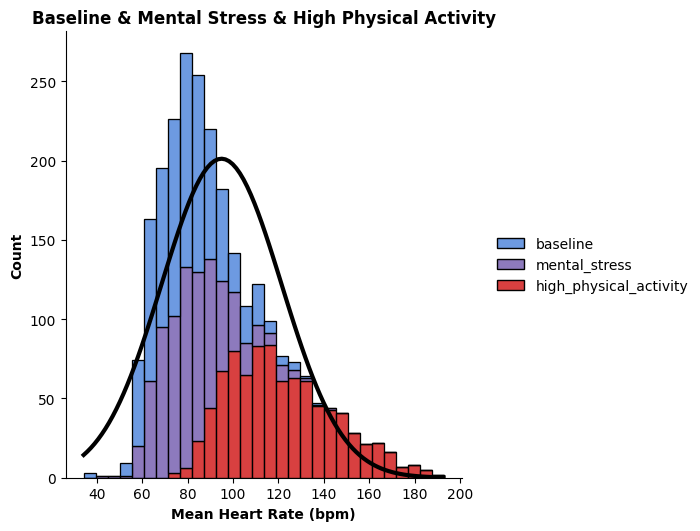

In [74]:
p = sns.displot({'baseline': list(baseline[hr_col]), 'mental_stress': list(mental_stress[hr_col]), 'high_physical_activity': list(high_physical_stress[hr_col])}, palette=['#3c78d8', '#674ea7', '#cc0000'], multiple='stack', kde=False, bins=30)
p.ax.set_title('Baseline & Mental Stress & High Physical Activity', fontweight='bold')
p.ax.set_xlabel('Mean Heart Rate (bpm)', fontweight='bold')
p.ax.set_ylabel('Count', fontweight='bold')	

df = pd.concat([baseline[hr_col], mental_stress[hr_col], high_physical_stress[hr_col]])
mean = df.mean()
std = df.std()

x = np.linspace(df.min(), df.max(), 100)
y = stats.norm.pdf(x, mean, std)

# Adjust the y-values to match the histogram
bin_width = (max(df) - min(df)) / 30
y_scaled = y * len(df) * bin_width

p.ax.plot(x, y_scaled, label='Normal Distribution', color='black', linewidth=3)

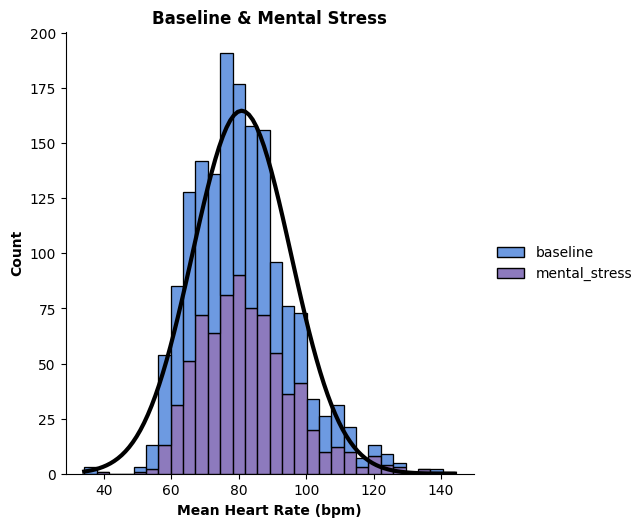

In [75]:
p = sns.displot({'baseline': list(baseline[hr_col]), 'mental_stress': list(mental_stress[hr_col])}, palette=['#3c78d8', '#674ea7'], multiple='stack', kde=False, bins=30)
p.ax.set_title('Baseline & Mental Stress', fontweight='bold')
p.ax.set_xlabel('Mean Heart Rate (bpm)', fontweight='bold')
p.ax.set_ylabel('Count', fontweight='bold')	

df = pd.concat([baseline[hr_col], mental_stress[hr_col]])
mean = df.mean()
std = df.std()

x = np.linspace(df.min(), df.max(), 100)
y = stats.norm.pdf(x, mean, std)

# Adjust the y-values to match the histogram
bin_width = (max(df) - min(df)) / 30
y_scaled = y * len(df) * bin_width

p.ax.plot(x, y_scaled, label='Normal Distribution', color='black', linewidth=3)

In [76]:
t_stat, p_value = stats.ttest_ind(baseline[hr_col], mental_stress[hr_col], equal_var=True)  # set equal_var=False if variances are not equal

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -3.4878087136595104
P-value: 0.0004998347660721374


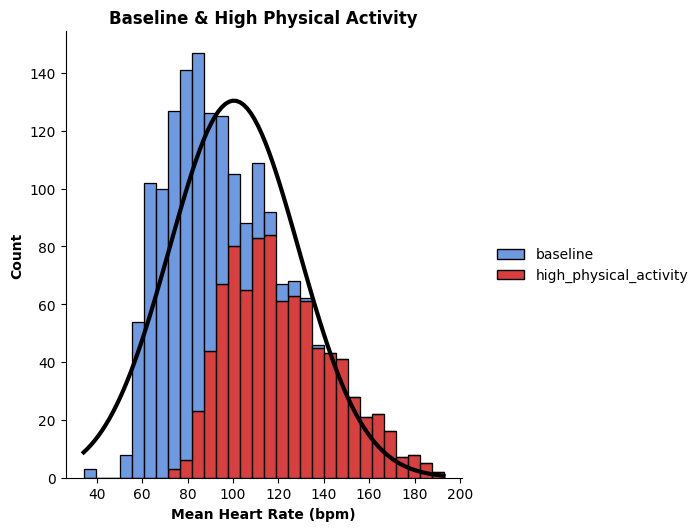

In [78]:
p = sns.displot({'baseline': list(baseline[hr_col]), 'high_physical_activity': list(high_physical_stress[hr_col])}, palette=['#3c78d8', '#cc0000'], multiple='stack', kde=False, bins=30)
p.ax.set_title('Baseline & High Physical Activity', fontweight='bold')
p.ax.set_xlabel('Mean Heart Rate (bpm)', fontweight='bold')
p.ax.set_ylabel('Count', fontweight='bold')	

df = pd.concat([baseline[hr_col], high_physical_stress[hr_col]])
mean = df.mean()
std = df.std()

x = np.linspace(df.min(), df.max(), 100)
y = stats.norm.pdf(x, mean, std)

# Adjust the y-values to match the histogram
bin_width = (max(df) - min(df)) / 30
y_scaled = y * len(df) * bin_width

p.ax.plot(x, y_scaled, label='Normal Distribution', color='black', linewidth=3)

In [77]:
len(baseline[hr_col]) + len(mental_stress[hr_col]) - 2

1642

In [34]:
import scipy.stats as stats

# Kruskal-Wallis Test
h_statistic, p_value_kw = stats.kruskal(baseline[hr_col], mental_stress[hr_col], high_physical_stress[hr_col])
print(f"Kruskal-Wallis Test: H={h_statistic}, p={p_value_kw}")

Kruskal-Wallis Test: H=1343.9683051219436, p=1.44874055072948e-292


Text(4.944444444444445, 0.5, 'Count')

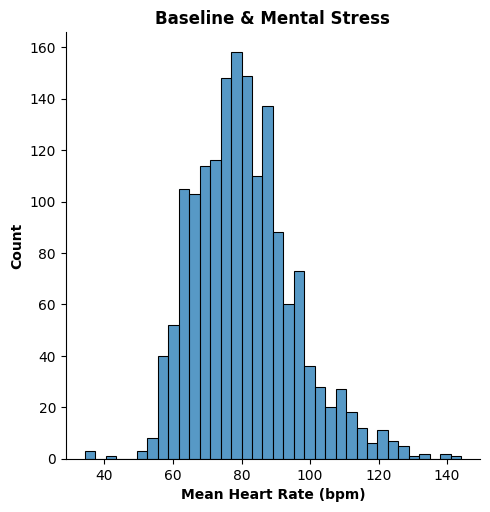

In [35]:
ax = sns.displot(pd.concat([baseline[hr_col], mental_stress[hr_col]])).ax
ax.set_title('Baseline & Mental Stress', fontweight='bold')
ax.set_xlabel('Mean Heart Rate (bpm)', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')	

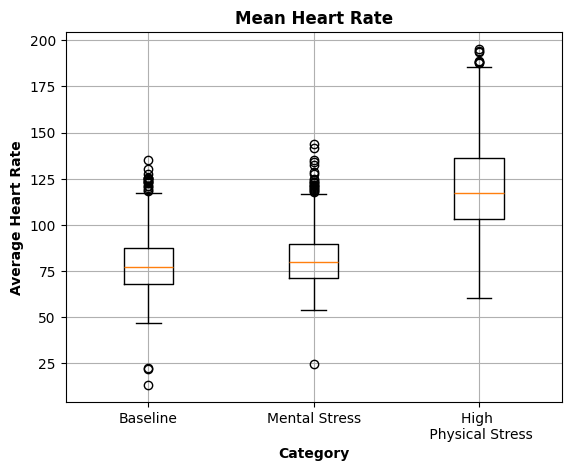

In [20]:
plt.boxplot([baseline[hr_col], mental_stress[hr_col], high_physical_stress[hr_col],], labels=[ 'Baseline', 'Mental Stress', 'High \n Physical Stress'])
plt.title('Mean Heart Rate', fontweight='bold')
plt.xlabel('Category', fontweight='bold')
plt.ylabel('Average Heart Rate', fontweight='bold')
plt.grid()
plt.show()

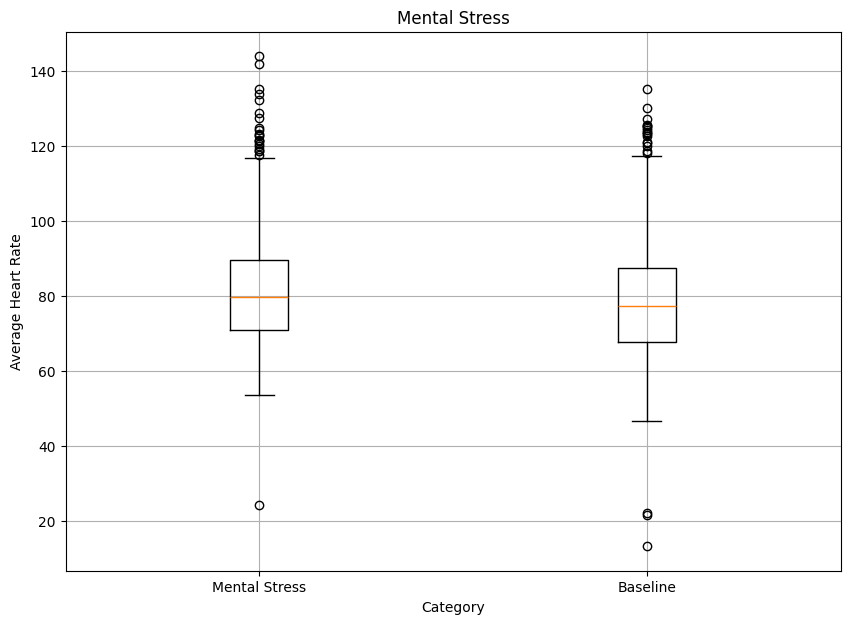

<Figure size 640x480 with 0 Axes>

In [153]:
fig, ax=plt.subplots(figsize=(10,7));

ax.boxplot([mental_stress[hr_col], baseline[hr_col]], labels=['Mental Stress', 'Baseline'])
ax.set_title('Mental Stress')
ax.set_xlabel('Category')
ax.set_ylabel('Average Heart Rate')
plt.grid()

plt.savefig(f'./figures/boxplots/mental_stress{file_postfix}.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

plt.clf()
plt.close(fig)

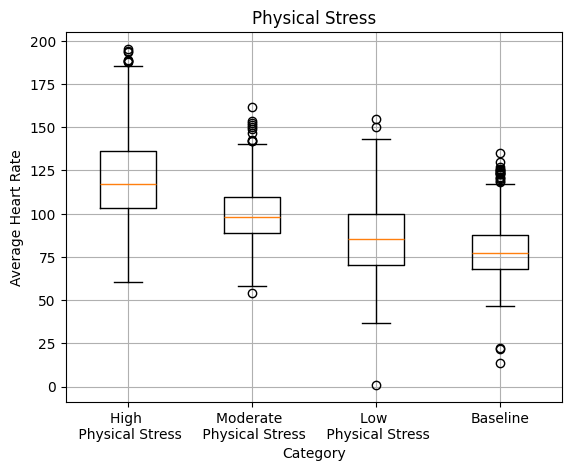

<Figure size 640x480 with 0 Axes>

In [154]:
plt.boxplot([high_physical_stress[hr_col], moderate_physical_stress[hr_col], low_physical_stress[hr_col], baseline[hr_col]], labels=['High \n Physical Stress', 'Moderate \n Physical Stress', 'Low \n Physical Stress', 'Baseline'])
plt.title('Physical Stress')
plt.xlabel('Category')
plt.ylabel('Average Heart Rate')
plt.grid()
plt.savefig(f'./figures/boxplots/physical_stress{file_postfix}.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
plt.clf()
plt.close(fig)

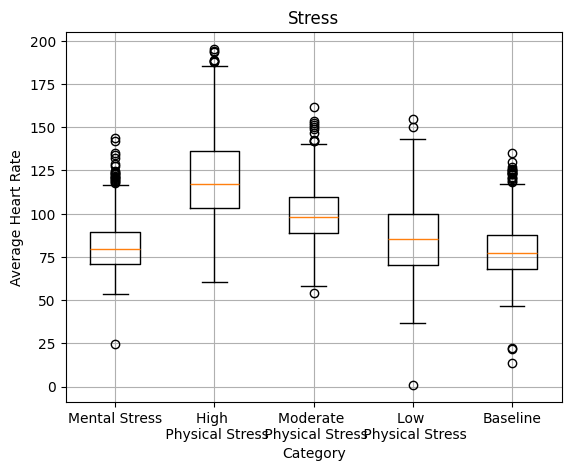

<Figure size 640x480 with 0 Axes>

In [155]:
plt.boxplot([mental_stress[hr_col], high_physical_stress[hr_col], moderate_physical_stress[hr_col], low_physical_stress[hr_col], baseline[hr_col]], labels=['Mental Stress', 'High \n Physical Stress', 'Moderate \n Physical Stress', 'Low \n Physical Stress', 'Baseline'])
plt.title('Stress')
plt.xlabel('Category')
plt.ylabel('Average Heart Rate')
plt.grid()
plt.savefig(f'./figures/boxplots/stress{file_postfix}.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
plt.clf()
plt.close(fig)

In [156]:
pd.set_option('display.max_rows', None)
pd.concat([
    mental_stress.groupby('subject_id').agg({hr_col: 'mean'}).reset_index().rename(columns={hr_col: 'mental_stress'}),
    high_physical_stress.groupby('subject_id').agg({hr_col: 'mean'}).reset_index().rename(columns={hr_col: 'high_physical_stress'}),
    moderate_physical_stress.groupby('subject_id').agg({hr_col: 'mean'}).reset_index().rename(columns={hr_col: 'moderate_physical_stress'}),
    low_physical_stress.groupby('subject_id').agg({hr_col: 'mean'}).reset_index().rename(columns={hr_col: 'low_physical_stress'}),
    baseline.groupby('subject_id').agg({hr_col: 'mean'}).reset_index().rename(columns={hr_col: 'baseline'})
]).groupby('subject_id').first().reset_index()

,subject_id,mental_stress,high_physical_stress,moderate_physical_stress,low_physical_stress,baseline
0,30100,67.864366,95.566675,79.894531,61.676473,52.034600
1,30101,89.352902,144.394716,114.466150,99.686922,92.339689
2,30103,101.254987,136.105569,110.735887,96.285388,90.208571
3,30104,77.788699,125.252925,102.319658,84.967907,79.423938
4,30105,97.488721,126.188537,111.862052,106.854293,97.782818
5,30106,83.972535,125.027684,99.849372,89.338586,80.720073
6,30107,93.632171,118.255609,121.334263,99.192844,91.868375
7,30108,86.637731,127.101051,103.394751,90.346930,85.297577
8,30109,64.590641,111.225290,88.465217,66.301030,65.881011
9,30110,74.722714,102.038388,82.096224,76.214987,62.128810


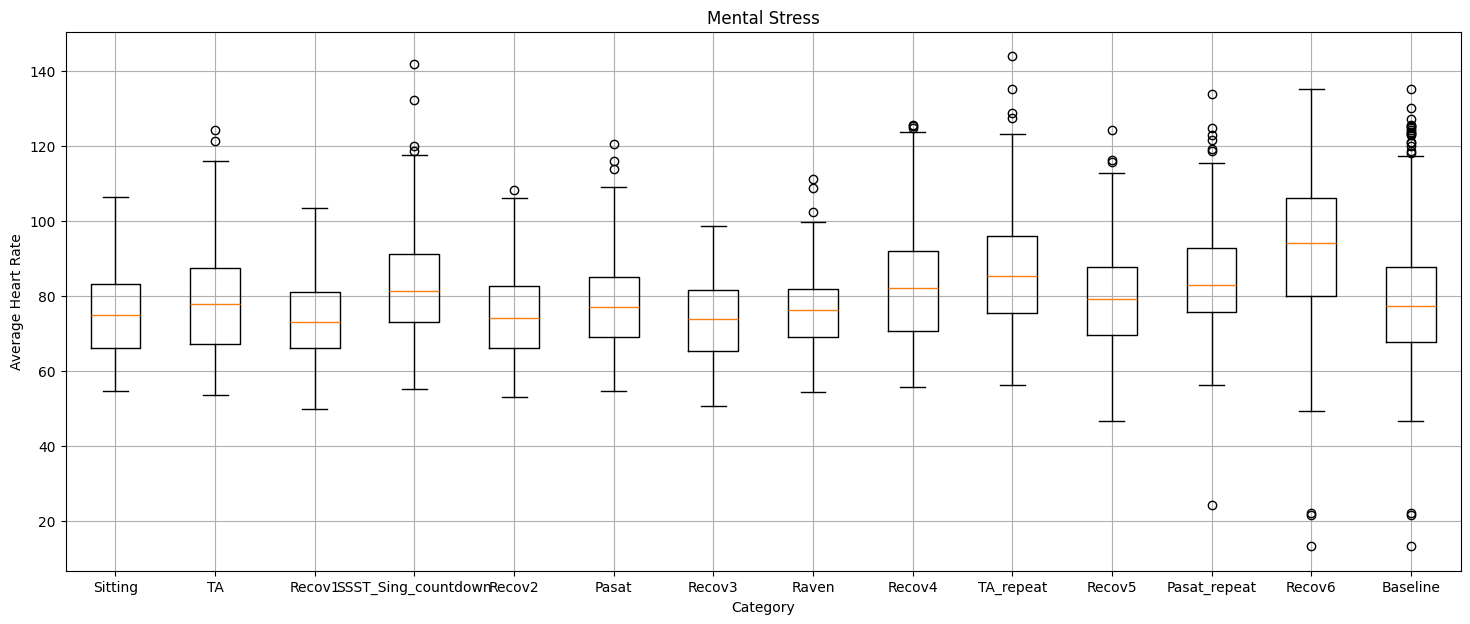

<Figure size 640x480 with 0 Axes>

In [157]:
fig, ax=plt.subplots(figsize=(18,7));

boxplot_data = [mental_stress[mental_stress['category'] == category][hr_col] for category in mental_stress['category'].unique() ] 
boxplot_data += [baseline[baseline['category'] == category][hr_col] for category in baseline['category'].unique()]
boxplot_data += [baseline[hr_col]]

boxplot_labels = np.append(
    mental_stress['category'].unique(), 
    baseline['category'].unique()
)
boxplot_labels = np.append(boxplot_labels, ['Baseline'])

zipped_data = zip(boxplot_labels, boxplot_data)
def get_index(item):
    return category_order.index(item[0])
sorted_zipped = sorted(zipped_data, key=get_index)

ax.boxplot([item[1] for item in sorted_zipped], labels=[item[0] for item in sorted_zipped])
ax.set_title('Mental Stress')
ax.set_xlabel('Category')
ax.set_ylabel('Average Heart Rate')
plt.grid()

plt.savefig(f'./figures/boxplots/mental_stress_individual{file_postfix}.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

plt.clf()
plt.close(fig)

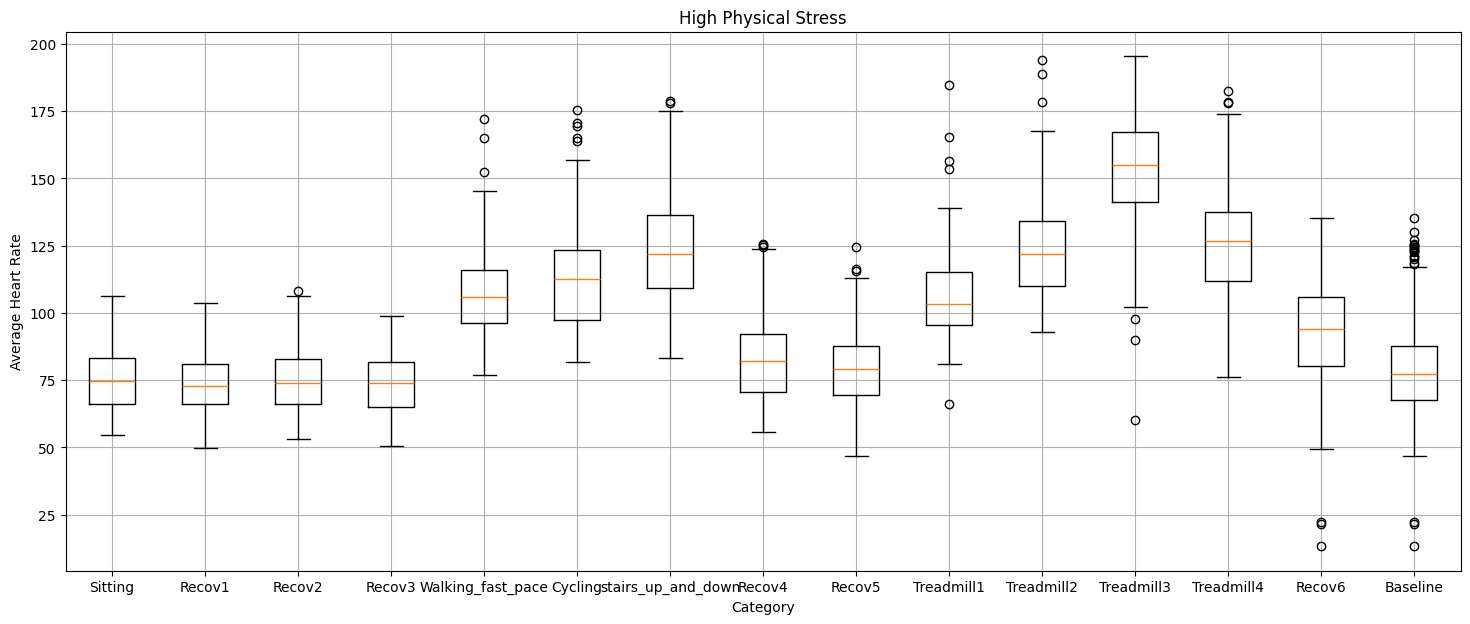

<Figure size 640x480 with 0 Axes>

In [158]:
fig, ax=plt.subplots(figsize=(18,7));

boxplot_data = [high_physical_stress[high_physical_stress['category'] == category][hr_col] for category in high_physical_stress['category'].unique() ] 
boxplot_data += [baseline[baseline['category'] == category][hr_col] for category in baseline['category'].unique()]
boxplot_data += [baseline[hr_col]]

boxplot_labels = np.append(
    high_physical_stress['category'].unique(), 
    baseline['category'].unique()
)
boxplot_labels = np.append(boxplot_labels, ['Baseline'])

zipped_data = zip(boxplot_labels, boxplot_data)
def get_index(item):
    return category_order.index(item[0])
sorted_zipped = sorted(zipped_data, key=get_index)

ax.boxplot([item[1] for item in sorted_zipped], labels=[item[0] for item in sorted_zipped])
ax.set_title('High Physical Stress')
ax.set_xlabel('Category')
ax.set_ylabel('Average Heart Rate')
plt.grid()

plt.savefig(f'./figures/boxplots/high_physical_stress_individual{file_postfix}.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

plt.clf()
plt.close(fig)

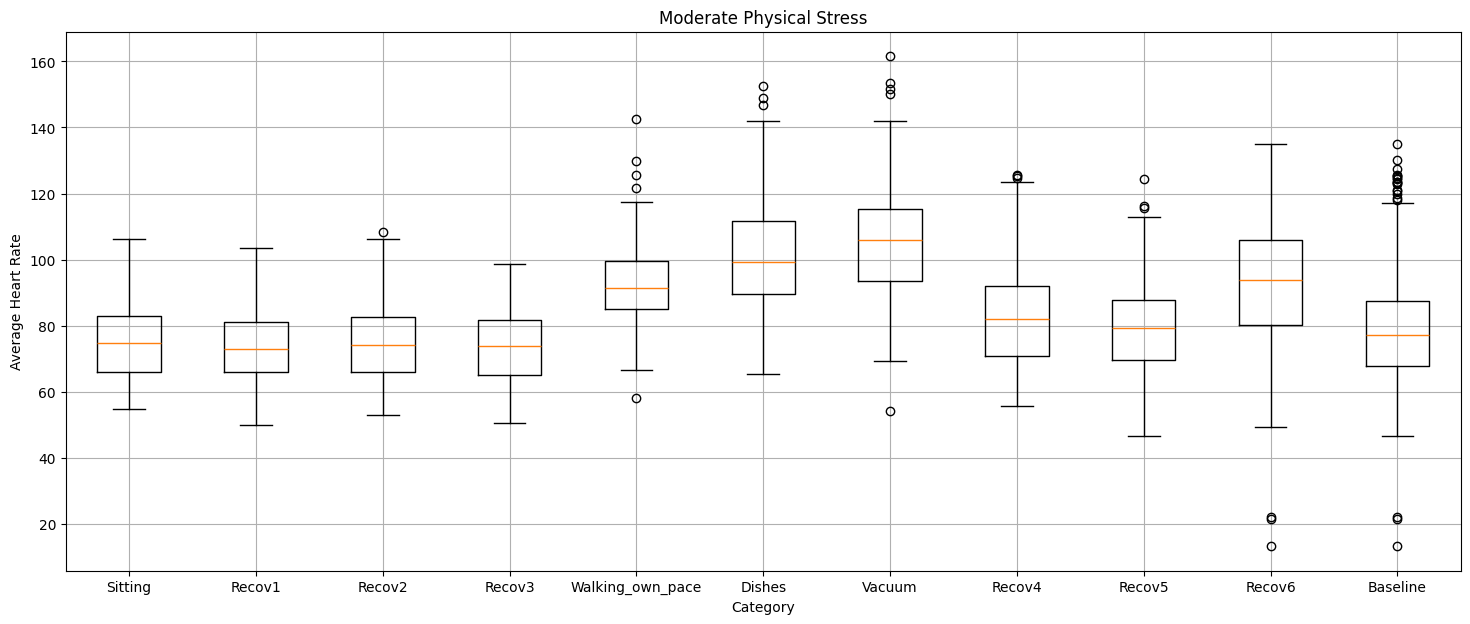

<Figure size 640x480 with 0 Axes>

In [159]:
fig, ax=plt.subplots(figsize=(18,7));

boxplot_data = [moderate_physical_stress[moderate_physical_stress['category'] == category][hr_col] for category in moderate_physical_stress['category'].unique() ] 
boxplot_data += [baseline[baseline['category'] == category][hr_col] for category in baseline['category'].unique()]
boxplot_data += [baseline[hr_col]]

boxplot_labels = np.append(
    moderate_physical_stress['category'].unique(), 
    baseline['category'].unique()
)
boxplot_labels = np.append(boxplot_labels, ['Baseline'])

zipped_data = zip(boxplot_labels, boxplot_data)
def get_index(item):
    return category_order.index(item[0])
sorted_zipped = sorted(zipped_data, key=get_index)

ax.boxplot([item[1] for item in sorted_zipped], labels=[item[0] for item in sorted_zipped])
ax.set_title('Moderate Physical Stress')
ax.set_xlabel('Category')
ax.set_ylabel('Average Heart Rate')
plt.grid()

plt.savefig(f'./figures/boxplots/moderate_physical_stress_individual{file_postfix}.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

plt.clf()
plt.close(fig)

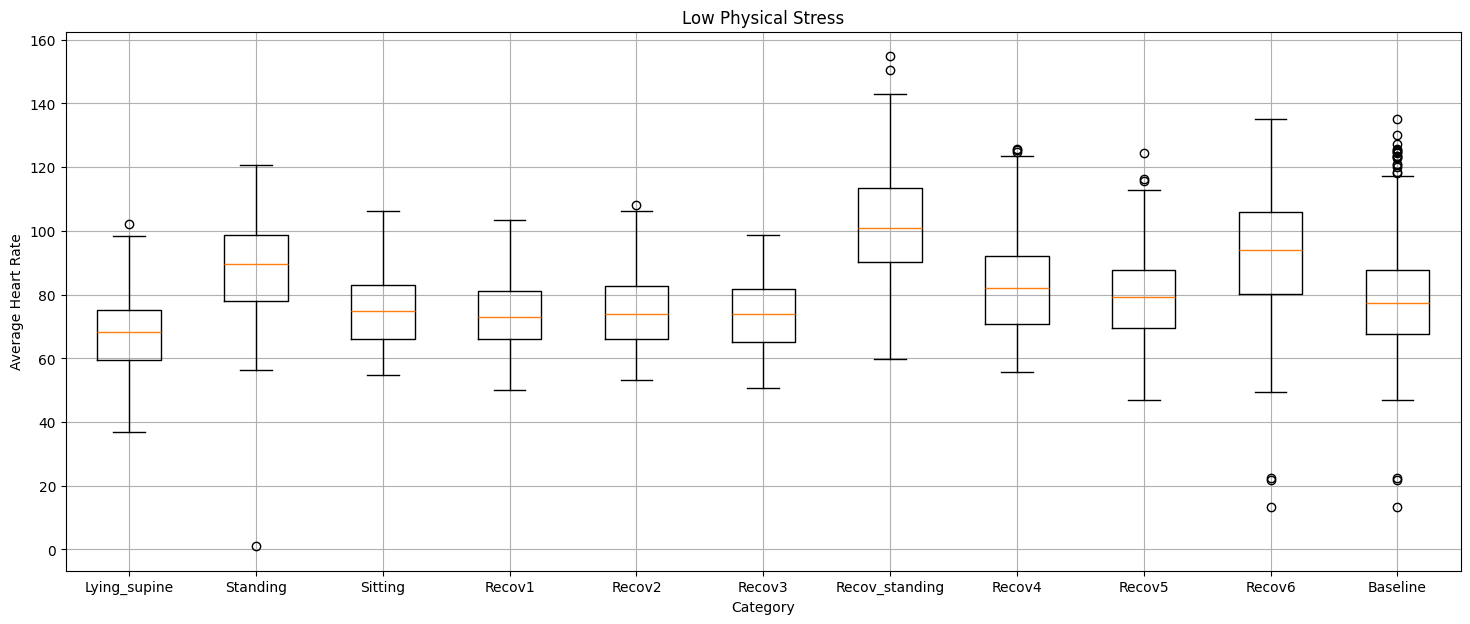

<Figure size 640x480 with 0 Axes>

In [160]:
fig, ax=plt.subplots(figsize=(18,7));

boxplot_data = [low_physical_stress[low_physical_stress['category'] == category][hr_col] for category in low_physical_stress['category'].unique() ] 
boxplot_data += [baseline[baseline['category'] == category][hr_col] for category in baseline['category'].unique()]
boxplot_data += [baseline[hr_col]]

boxplot_labels = np.append(
    low_physical_stress['category'].unique(), 
    baseline['category'].unique()
)
boxplot_labels = np.append(boxplot_labels, ['Baseline'])

zipped_data = zip(boxplot_labels, boxplot_data)
def get_index(item):
    return category_order.index(item[0])
sorted_zipped = sorted(zipped_data, key=get_index)

ax.boxplot([item[1] for item in sorted_zipped], labels=[item[0] for item in sorted_zipped])
ax.set_title('Low Physical Stress')
ax.set_xlabel('Category')
ax.set_ylabel('Average Heart Rate')
plt.grid()

plt.savefig(f'./figures/boxplots/low_physical_stress_individual{file_postfix}.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

plt.clf()
plt.close(fig)

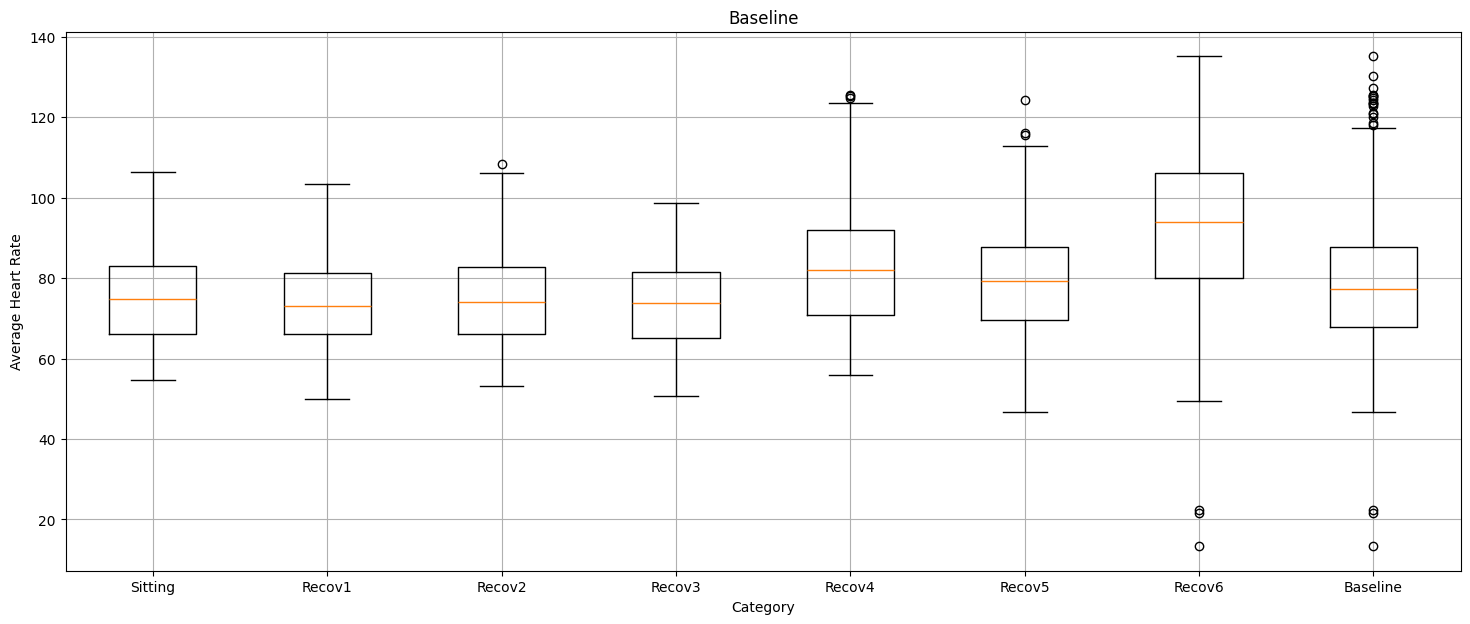

<Figure size 640x480 with 0 Axes>

In [161]:
fig, ax=plt.subplots(figsize=(18,7));

boxplot_data = [baseline[baseline['category'] == category][hr_col] for category in baseline['category'].unique() ] 
boxplot_data += [baseline[hr_col]]

boxplot_labels = np.append(baseline['category'].unique(), ['Baseline'])

zipped_data = zip(boxplot_labels, boxplot_data)
def get_index(item):
    return category_order.index(item[0])
sorted_zipped = sorted(zipped_data, key=get_index)

ax.boxplot([item[1] for item in sorted_zipped], labels=[item[0] for item in sorted_zipped])

ax.set_title('Baseline')
ax.set_xlabel('Category')
ax.set_ylabel('Average Heart Rate')
plt.grid()

plt.savefig(f'./figures/boxplots/baseline_individual{file_postfix}.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

plt.clf()
plt.close(fig)

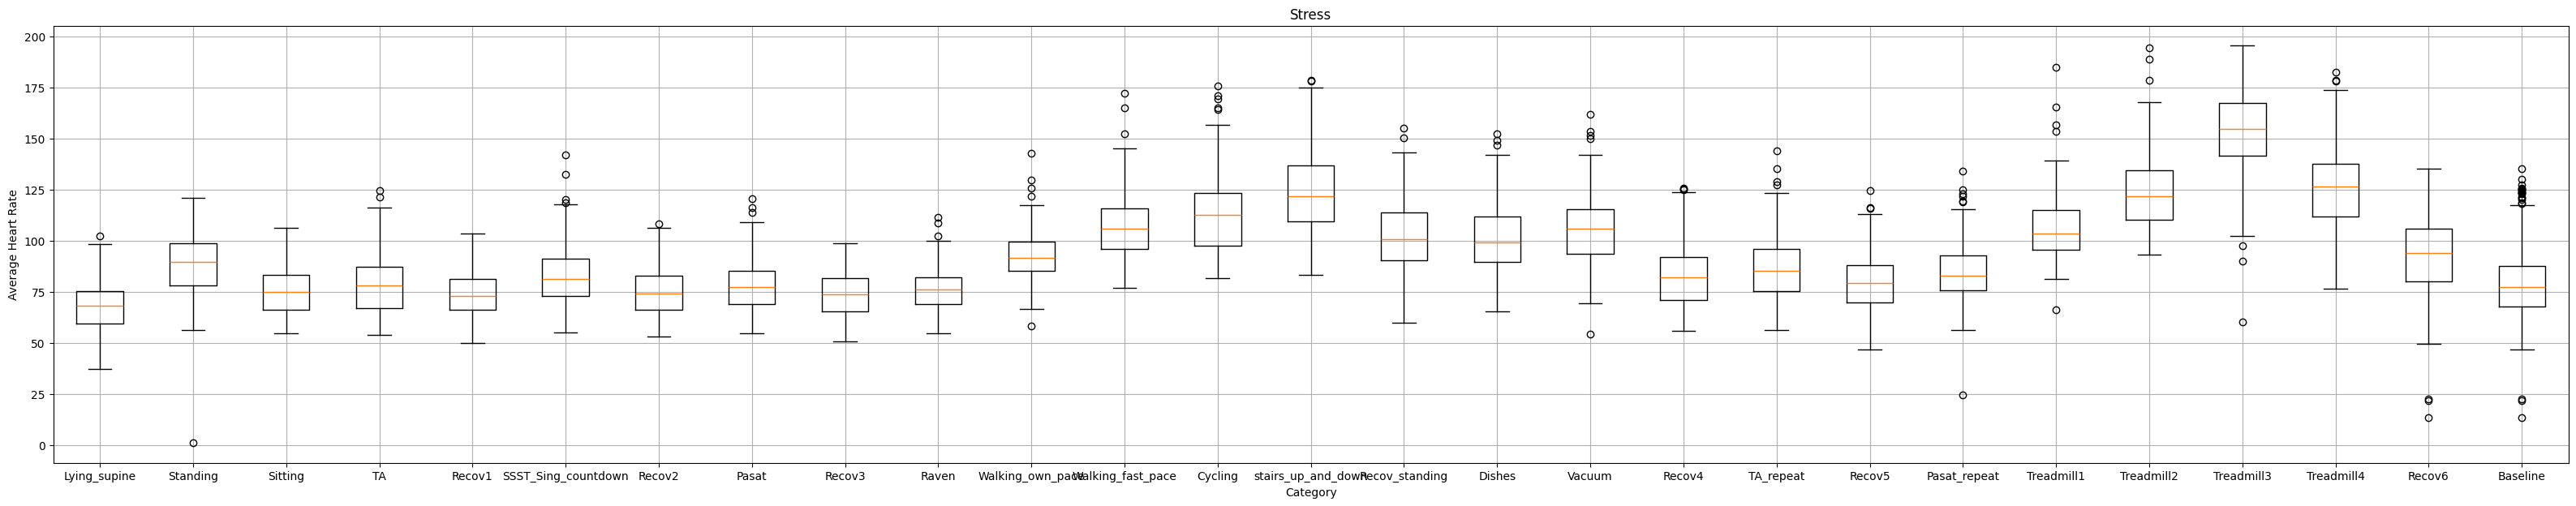

<Figure size 640x480 with 0 Axes>

In [162]:
fig, ax=plt.subplots(figsize=(40,7));

boxplot_data = [rates[rates['category'] == category][hr_col] for category in rates['category'].unique() ] 
boxplot_data += [baseline[hr_col]]

boxplot_labels = np.append(rates['category'].unique(), ['Baseline'])

zipped_data = zip(boxplot_labels, boxplot_data)
def get_index(item):
    return category_order.index(item[0])
sorted_zipped = sorted(zipped_data, key=get_index)

ax.boxplot([item[1] for item in sorted_zipped], labels=[item[0] for item in sorted_zipped])
ax.set_title('Stress')
ax.set_xlabel('Category')
ax.set_ylabel('Average Heart Rate')
plt.grid()

plt.savefig(f'./figures/boxplots/stress_individual{file_postfix}.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

plt.clf()
plt.close(fig)